In [1]:
%matplotlib inline
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [3]:
#function to get file names for each image
def file_names(folder):
    names = []
    for filename in os.listdir(folder):
        names.append(filename[4:len(filename)-4])
    return names

In [4]:
train_images = load_images_from_folder("DatasetWithoutRotations/Training/png")

In [5]:
def show_rgb_img(img):
    return plt.imshow(cv2.cvtColor(img, cv2.CV_32S))

def gen_sift_features(img):
    sift = cv2.SIFT_create()
    kp, desc = sift.detectAndCompute(img, None)
    return kp, desc

def show_sift_features(img, kp):
    return show_rgb_img(cv2.drawKeypoints(img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))

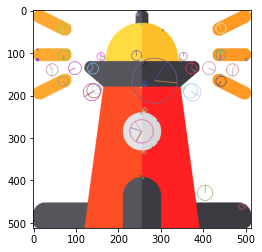

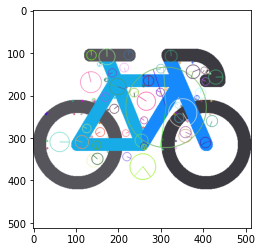

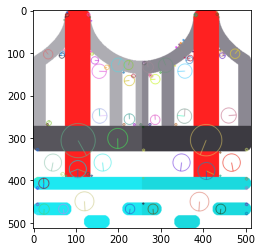

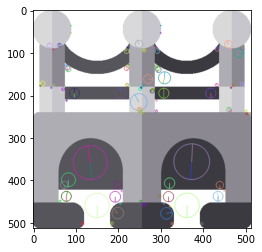

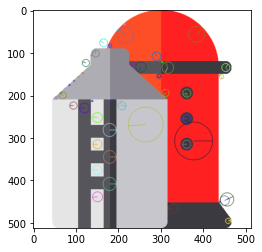

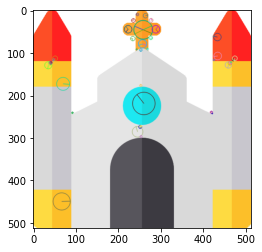

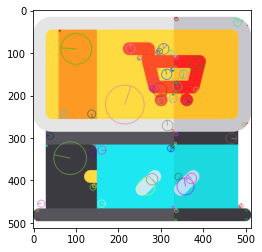

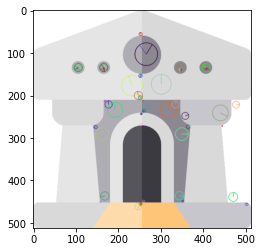

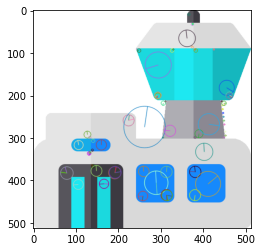

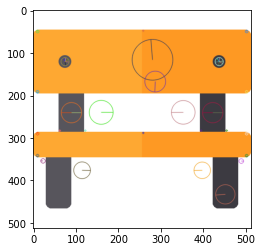

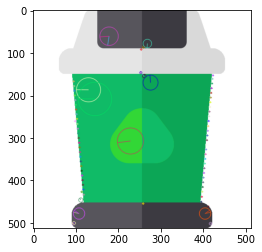

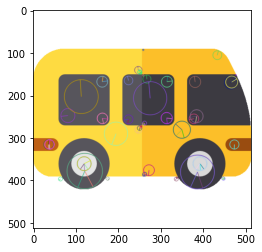

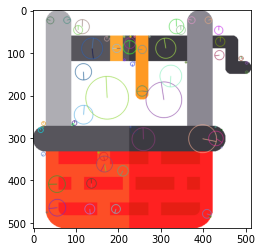

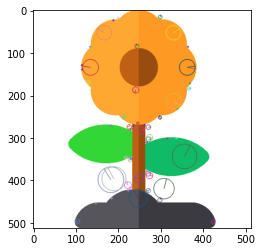

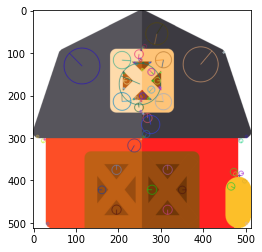

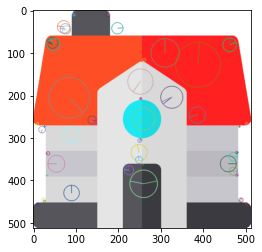

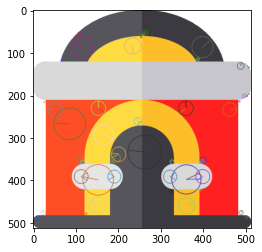

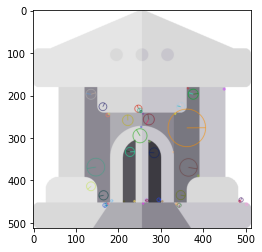

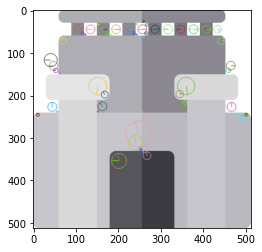

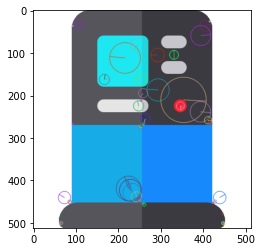

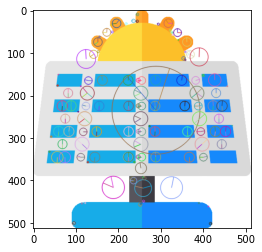

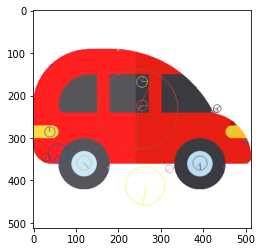

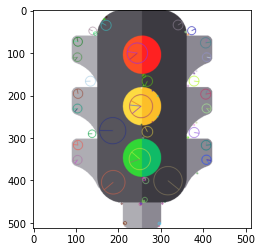

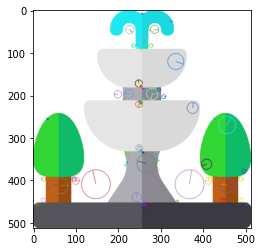

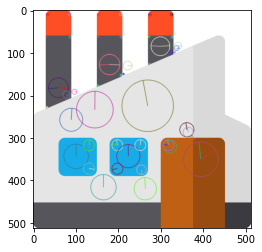

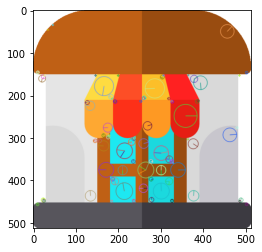

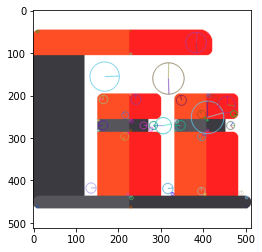

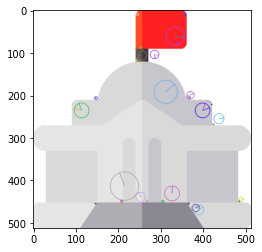

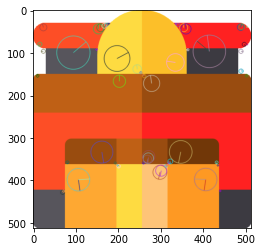

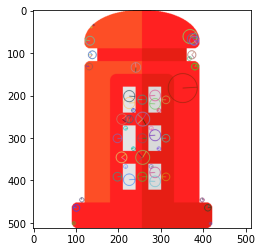

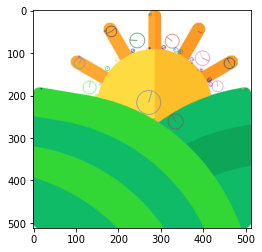

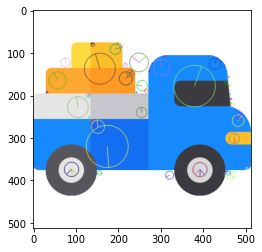

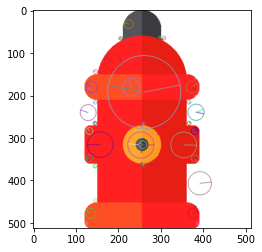

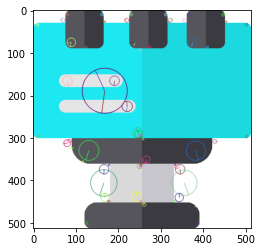

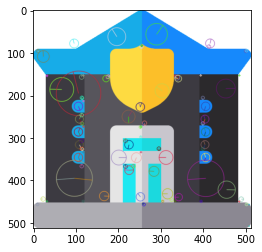

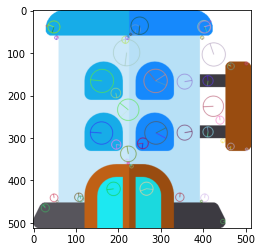

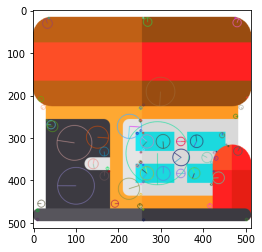

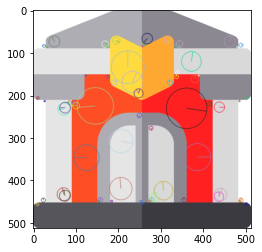

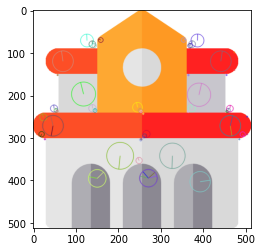

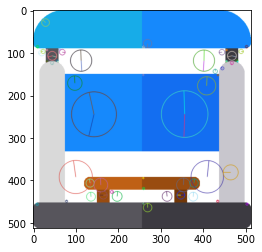

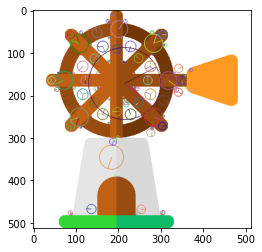

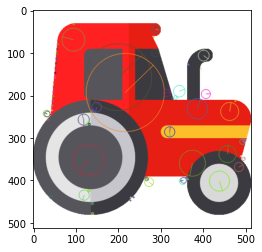

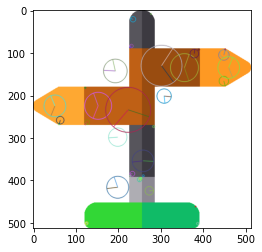

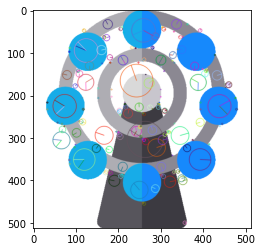

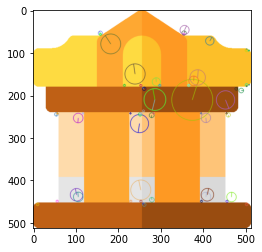

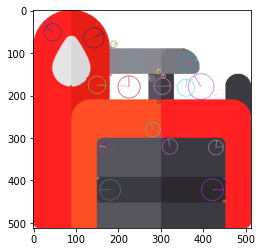

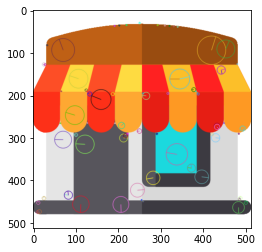

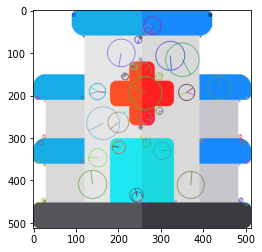

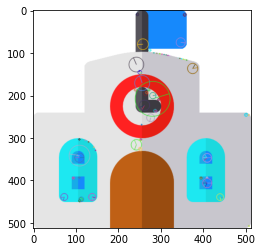

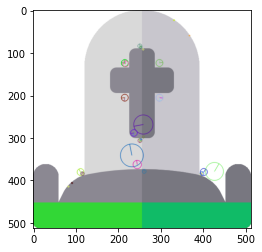

In [6]:
#explore keypoints for each icon
for i in range(len(train_images)):
    trainImgKp, trainimgDesc = gen_sift_features(train_images[i])
    show_sift_features(train_images[i], trainImgKp)
    plt.show()

In [7]:
test_images = load_images_from_folder("DatasetWithoutRotations/TestWithoutRotations/images")

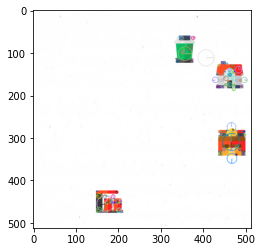

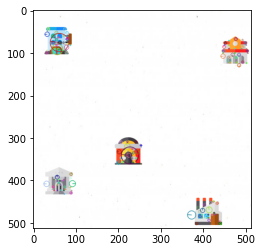

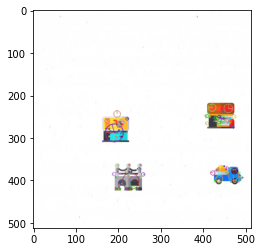

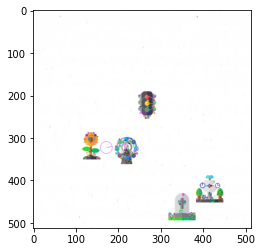

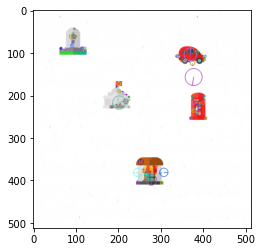

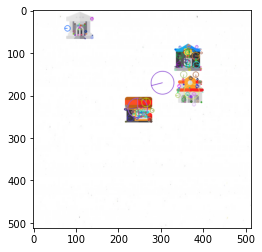

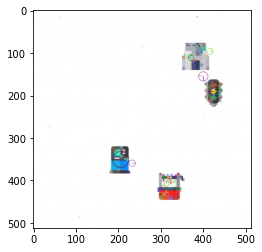

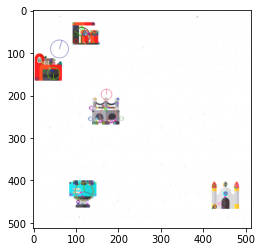

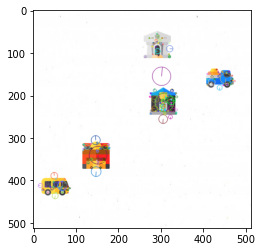

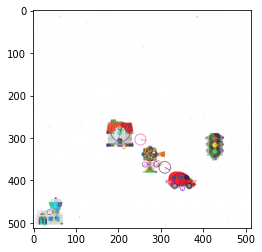

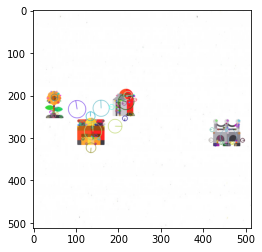

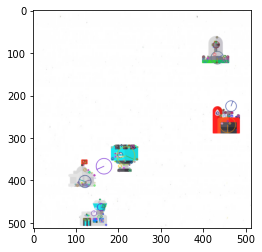

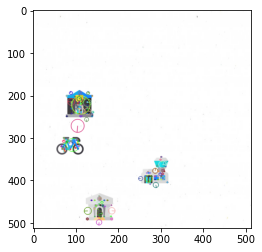

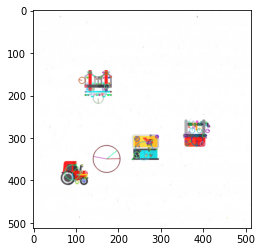

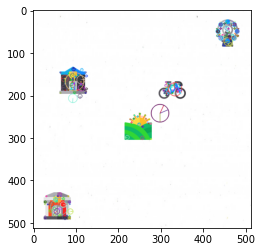

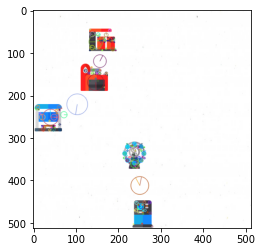

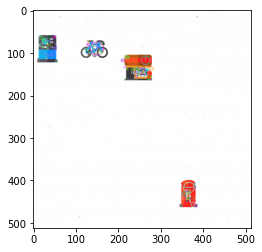

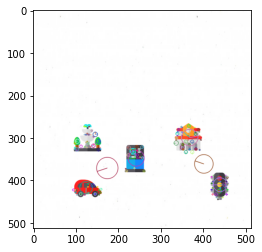

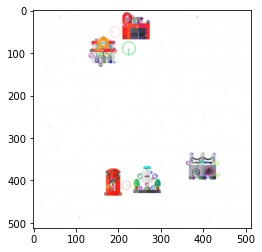

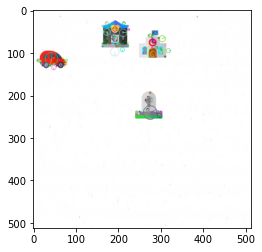

In [8]:
#explore keypoints for each test image
for i in range(len(test_images)):
    testImgKp, testDesc = gen_sift_features(test_images[i])
    show_sift_features(test_images[i], testImgKp)
    plt.show()

In [9]:
#for an image in train set, compare all test images using brute force matcher
def lookAtMatches(trainImg, testImages):
    
    trainImgKp, trainimgDesc = gen_sift_features(to_gray(trainImg))
    
    for i in range(len(testImages)):
        
        testImgKp, testDesc = gen_sift_features(to_gray(testImages[i]))
        matches = bf.knnMatch(trainimgDesc, testDesc,k=2)

        good = []
        for m,n in matches:
            if m.distance < 0.75 * n.distance:
                good.append([m])

        match_img = cv2.drawMatchesKnn(
            trainImg, trainImgKp,
            testImages[i], testImgKp,
            good, None, flags=2)
        
        if len(good)>=30:
            plt.figure(figsize=(12,6))
            plt.imshow(match_img);
            print(len(good)," ", i)
        

In [10]:
#for an image in train set, compare all test images using flann matcher
def lookAtMatches2(img1, img2):
    
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    
    for i in range(len(img2)):
        
        kp2, des2 = sift.detectAndCompute(img2[i], None)
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=100)

        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des1, des2, k=2)

        good = []
        for m,n in matches:
            if m.distance < 0.75 * n.distance:
                good.append([m])

        match_img = cv2.drawMatchesKnn(
            img1, kp1,
            img2[i], kp2,
            good, None, flags=2)
        
        if len(good)>=5:
            plt.figure(figsize=(12,6))
            plt.imshow(match_img);
            #print(len(good)," ", i)
   

In [11]:
#for i in range(len(train_images)):
#    lookAtMatches2(train_images[i],test_images)

In [12]:
# main function used which extracts keypoints and descriptors, compares them, filters out outliers, and then adds a bounding
# box
def siftWithRansac(img1, img2, name = None, minMatch = 10, ratio = 0.7,ransacThresh = 8.0):


    sift = cv2.SIFT_create()#edgeThreshold = 10)

    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=100)
    
    bf = cv2.BFMatcher()
    #matches = bf.knnMatch(des1, des2,k=2)
    
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    good = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good.append(m)
    location = ""

    if len(good) > minMatch:
        
        #collect location of keypoints which matched and convert them into appropirate shape
        
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransacThresh)
        
        if M is None:
            return None, location
        
        h, w, _= img1.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts, M)
        img2 = cv2.polylines(img2, [np.int32(dst)], True, (0, 0, 255), 3,cv2.LINE_AA)
        if dst is not None:
            #create label identical to 'attributes' text files for easy  comparisson
            location = (name + ", " + "(" + str(int(dst[0][0][0])) + ", " +
                        str(int(dst[0][0][1])) +")" + ", " + "(" +
                        str(int(dst[2][0][0])) + ", " + str(int(dst[2][0][1])) +")\n")
            img2 = cv2.putText(img2, name, (int(dst[0][0][0]),int(dst[0][0][1]-10)), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,0,0), 1)


    else: 
        return None, location
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    return img2, location

In [13]:
iconNames = file_names("DatasetWithoutRotations/Training/png")

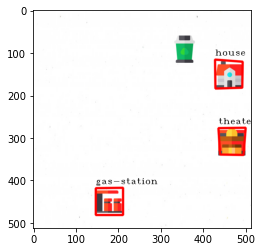

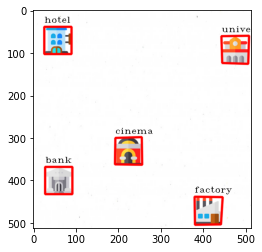

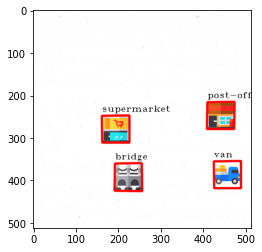

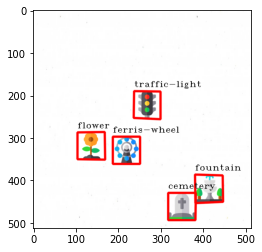

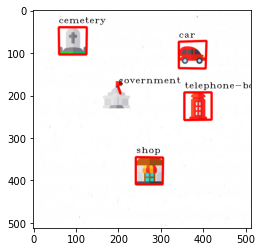

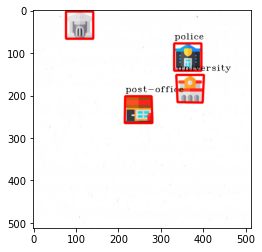

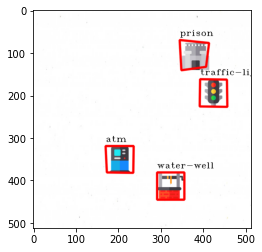

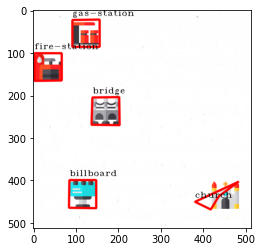

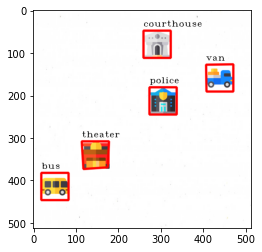

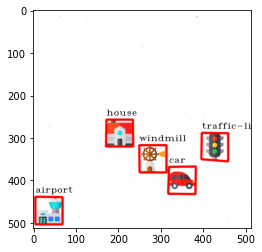

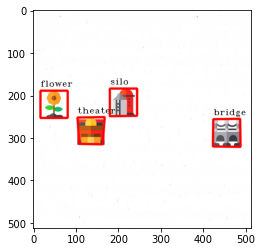

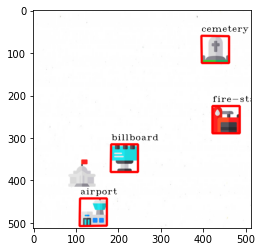

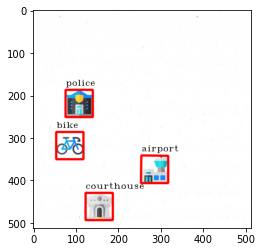

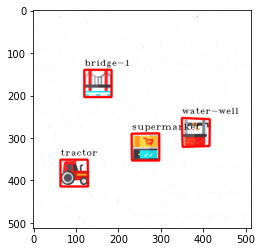

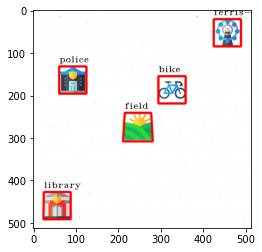

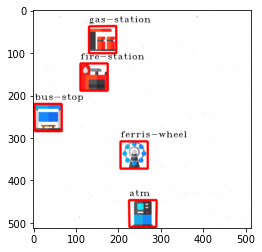

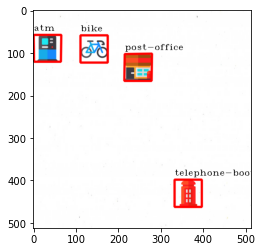

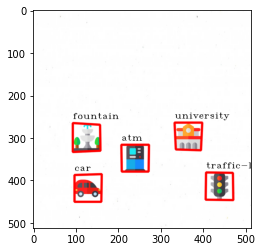

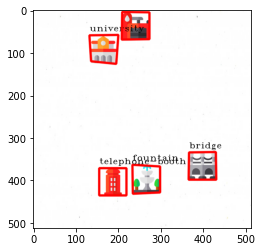

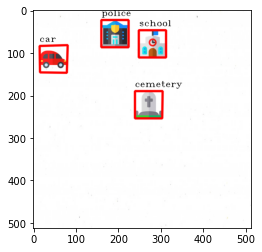

Wall time: 2min 2s


In [14]:
%%time
images = [""]*(len(test_images))
labels = [""]*(len(test_images))
for i in range(len(test_images)):
    for j in range(len(train_images)):
        labelledIm, label = siftWithRansac(train_images[j], test_images[i],iconNames[j], 4, 0.55, 5.0)
        if len(label) > len(iconNames[j]) + 12:
             labels[i] = labels[i] + label
        if labelledIm is not None:
             images[i]=labelledIm
            
for image in images:
    plt.imshow(image),plt.show()    

In [15]:
# tuning hyper parameters
#7, 0.60, 7.5 - 85.25
#3, 0.45, 4.0 - 82.75
#4, 0.45, 5.0 - 83.75
#4, 0.50, 5.0 - 86.75
#4, 0.55, 5.0 - 94.5
#4, 0.60, 5.0 - 88.75
#4, 0.57, 5.0 - 91.0
#5, 0.55, 5.0 - 93.5

In [16]:
#function just to look at the results
def compare_to_annotations(labels, folder, fileNum):
    
    files = os.listdir(folder)
    file = open(str(folder + "\\" + files[fileNum]))
    comparisson = files[fileNum] + "\n\n"
    
    for line in file:
        found = 0
        #split name off so it can be compared to the found label
        name, vals = line.split(',',1)
        comparisson = comparisson + name + "\n" + "given" + vals
        for line1 in labels.splitlines():
            name1, vals1 = line1.split(',',1)
            if name == name1:
                found = 1
                comparisson = comparisson + "found" + vals1 + "\n\n"
        if found == 0:
            comparisson = comparisson + "not found\n\n"
            
    return comparisson           

In [17]:
for i in range(len(test_images)):
    comp = compare_to_annotations(labels[i],"DatasetWithoutRotations/TestWithoutRotations/annotations", i+1)
    print(comp)

test_image_1.txt

gas-station
given (148, 418), (212, 482)
found (147, 418), (211, 481)

trash
given (324, 60), (388, 124)
not found

theater
given (435, 278), (499, 342)
found (435, 277), (494, 340)

house
given (430, 120), (494, 184)
found (427, 116), (491, 182)


test_image_10.txt

factory
given (380, 441), (444, 505)
found (379, 438), (441, 503)

hotel
given (27, 40), (91, 104)
found (26, 39), (90, 103)

university
given (443, 62), (507, 126)
found (442, 61), (505, 126)

bank
given (29, 369), (93, 433)
found (28, 368), (92, 432)

cinema
given (192, 299), (256, 363)
found (193, 300), (256, 363)


test_image_11.txt

supermarket
given (162, 248), (226, 312)
found (161, 248), (226, 311)

post-office
given (409, 216), (473, 280)
found (409, 216), (472, 279)

bridge
given (192, 360), (256, 424)
found (192, 360), (256, 425)

van
given (425, 355), (489, 419)
found (424, 355), (488, 418)


test_image_12.txt

flower
given (105, 287), (169, 351)
found (104, 287), (169, 351)

cemetery
given (3

In [18]:
import re
def get_accuracy(labels, folder, fileNum):
    
    files = os.listdir(folder)
    file = open(str(folder + "\\" + files[fileNum]))
    correct = 0
    total = 0
    for line in file:
        total = total + 1
        
        name, *vals = line.split(',')
        values = []
        for x in vals:  
            values.append(re.sub("[^0-9]", "",x))
        values = [int(x) for x in values]
        for line1 in labels.splitlines():
            name1, *vals1 = line1.split(',')
            values1 = []
            for x in vals1:  
                values1.append(re.sub("[^0-9]", "",x))
            values1 = [int(x) for x in values1]
            #check if correctly labelled
            if name == name1:
                valueDiff = [a - b for a, b in zip(values, values1)]
                #checks if found co-ordintates are correct to a degree
                if all(ele >= -5 and ele <= 5 for ele in valueDiff):
                    correct = correct + 1
    return (correct/total * 100)

In [19]:
total = 0
for i in range(len(test_images)):
    acc = get_accuracy(labels[i],"DatasetWithoutRotations/TestWithoutRotations/annotations", i+1)
    total = total + acc
totalAcc = total/len(test_images)
print("Total Accuracy: " + str(totalAcc))

Total Accuracy: 94.5
